In this lab, a [Shazam](http://bit.ly/1fvTDIQ)-similar system is implemented. An complete [acoustic fingerprint](https://en.wikipedia.org/wiki/Acoustic_fingerprint) of a song is generated by hashing the **frequency and time** information in the spectrogram. A fingerprint of a snippet (a brief extract of a song) is later generated and searched through the database of hashes. A high number of matches is found if the snippet comes from the corresponding song. 

# Shazam: Audio Recognition System

As usual, we set the pylab inline option and import necessary modules. 

In [43]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab #plotting spectrogram
from scipy.ndimage.filters import maximum_filter # find the peaks in the spectrogram
from scipy.ndimage.morphology import (generate_binary_structure,iterate_structure)
from scipy.io.wavfile import read, write #read and write wav files.
import hashlib # to generate hash from the frequency and time information

%matplotlib inline

# Exercise 1:
Write a function called readAudioFile to read the **wav** file. *limit* is the number of seconds from the beginning of the song we would like to read. If *limit* is None, readAudioFile returns the data for the whole song. 

In [44]:
def readAudioFile(filename, limit = None):
    # channels is a list. 
    # channel[0] is the first channel of the audio file. channel[1] is the second channel of the audio file
    rate, data = read(filename)
    if limit:
        limit = limit * rate
    channels = []
    for chn in range(data.shape[1]):
        if limit:
            single = data[:limit, chn]
        else:
            single = data[:, chn]
        channels.append(single)
    return channels, rate

We will implement the Shazam [paper](http://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf). We will refer to figures in this paper. 
Next we define two functions:

1. **get_2D_peaks**: Find the peaks in the spectrogram. Refer to figure 1B of the paper. The set of peaks of the spectrogram is also called the constellation map. 
2. **generate_hashes**: Generate the hashes from the constellation map. See figure 1C and 1D. The struture of the hashes is [f1:f2:delta_t]:t1. Then we call the hashlib function sha1 to generate a single number for our hash. For this demo, I keep the first 25 values of the hash. 

***Question***: does the accuracy of the algorithm increase or decrease if you increase the number of hashes to keep?

In [45]:
def get_2D_peaks(arr2D, plot,amp_min = 10):
    struct   = generate_binary_structure(2,1)
    neighborhood  = iterate_structure(struct, 20)
    detected_peaks = maximum_filter(arr2D, footprint  = neighborhood) == arr2D
    amps = arr2D[detected_peaks]
    j,i  = np.where(detected_peaks) 
    amps = amps.flatten()
    peaks = zip(j,i, amps)
    peaks_filtered = [x for x in peaks if x[2]>amp_min]
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]
    if plot: 
        fig, ax = plt.subplots()
        ax.imshow(arr2D)
        ax.scatter(frequency_idx, time_idx)
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title("Spectrogram")
        plt.gca().invert_yaxis()
        plt.axis('tight')
    return zip(frequency_idx, time_idx)

def generate_hashes(peaks, fan_value = 10, len_hash = 25):
    fingerprinted = set()  
    for i in range(len(peaks)):
        for j in range(fan_value):
            if (i + j) < len(peaks) and not (i, i + j) in fingerprinted:
                freq1 = peaks[i][1]
                freq2 = peaks[i + j][1]
                t1 = peaks[i][0]
                t2 = peaks[i + j][0]
                t_delta = t2 - t1
                if t_delta >= 0:
                    h = hashlib.sha1("%s|%s|%s" % (str(freq1), str(freq2), str(t_delta))) 
                    yield (h.hexdigest()[0:len_hash], t1)
                fingerprinted.add((i, i + j))             

**Increasing the number of hashes to keep decreases the accuracy of the algorithm because it increases the probability of hash collisions, and in extent false matches.**

The following function **fingerpint** returns the hashes of an audio file. 

In [46]:
def fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot):
    arr2D = mlab.specgram(samples, NFFT = wsize, Fs = Fs, window = mlab.window_hanning, noverlap = int(wsize * wratio))[0];
    arr2D = 10 * np.log10(arr2D+0.001)
    arr2D[arr2D == -np.inf] = 0
    local_maxima = get_2D_peaks(arr2D, plot, amp_min = amp_min)
    return generate_hashes(local_maxima, fan_value = fan_value, len_hash = 25)

Now we are ready to extract and save the fingerprints. First we read the audio file from the wav folder. You can input your own wav file there. Define the window size, overlap ratio between consecutive frames. 

In [48]:
channels, framerate = readAudioFile('data/Minh_Yeu_Nhau_Di_Bich_Phuong.wav')

wsize  = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
amp_min = 25 # minimum amplitude of the peak.

for samples in channels:
    hashes = fingerprint(samples, framerate, wsize, wratio, fan_value, amp_min, plot)

For easy visualization and explanation, we will convert our hases into a dictionary of the form: **dict[hash] = t1**. Dictionaries consist of pairs of **keys** and their corresponding **values**. We use the hashes as keys and the time of the hash as value. Since different segments from the audio file can produce the same hash, one key might correspond to multiple values (multiple starting times t1). We use the *defaultdict* data structure to accomodate multiple-valued-single-key entries. 

In [49]:
from collections import defaultdict
def hashesToDict(hashesExcerpt):
    dataExcerpt  = []
    for i in hashesExcerpt:
        dataExcerpt.append(i)
    dictExcerpt = defaultdict(list)
    for hashString, t1 in dataExcerpt:
        dictExcerpt[hashString].append(t1)
    return dictExcerpt

Now we convert the hashes to a dictionary called **dictOriginal**. **dictOriginal** contains all the hashes of the *'Minh_Yeu_Nhau_Di_Bich_Phuong.wav'* song. The key is the hash and the value is the time. See figure 1D in the paper.

In [50]:
dictOriginal = hashesToDict(hashes)

To implement searching, we could implement [mySQL](http://mysql-python.sourceforge.net/) databases. This provides a systematic approach to store, retrieve and search for hashes. mySQL requires a mySQL server, which adds a level of complexity to this project. For now, we only save the fingperprints into a file and later retrieve them if we need. 

In [51]:
import pickle
fileHandle  = open("MinhYeuNhauDi.fp","wb") #wb: write binary
pickle.dump(dictOriginal, fileHandle)

# Testing the System

Now we load the fingerprinted file back and store it as **dictOriginal**. You can fingerprint as many files as you want, then read all of them here. 

In [52]:
fileHandle = open("MinhYeuNhauDi.fp","rb")
dictOriginal = pickle.load(fileHandle)

# Exercise 2. 
Write a function called readAudioFileExcerpt with three inputs. The first input is the filename. The other two inputs are lowLimit and highLimit, which is used to read the audio file from lowLimit to highLimt **seconds**.

In [53]:
def readAudioFileExcerpt(filename, lowLimit, highLimit):
    framerate, data = read(filename)
    lowLimit = lowLimit * framerate
    highLimit = highLimit * framerate
    channels = []
    for chn in range(data.shape[1]):
        channels.append(data[lowLimit:highLimit, chn])
    return channels, framerate

# Excercise 3
Use your function to read the excerpt from the *Minh_Yeu_Nhau_Di_Bich_Phuong.wav* and generate the hashes from this snippet. Name the hahses **hashesExcerpt1**. Also, we've set the plot parameter to True to visualize the peaks of the spectrogram. What parameters in the **fingerprint** function affect the number of peaks?

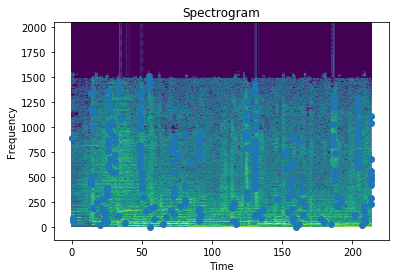

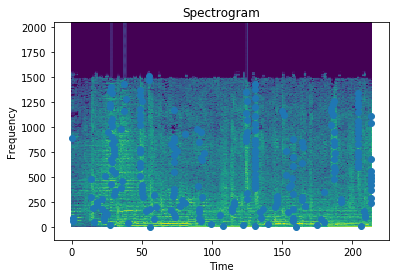

In [54]:
# write your code here.
# read in the audio snippit from 40s to 50s
channelsExcerpt1, framerate = readAudioFileExcerpt('data/Minh_Yeu_Nhau_Di_Bich_Phuong.wav',40,50)
plot = True # but now we want to visualize the peak (pass this as a parameter to get_2D_peaks)
# call the fingerprint function to generate the hashes.

wsize  = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
amp_min = 25 # minimum amplitude of the peak.

for samples in channelsExcerpt1:
    hashesExcerpt1 = fingerprint(samples, framerate, wsize, wratio, fan_value, amp_min, plot)

Now we convert the **hashesExcerpt1** to a dictionary. We can call the **hashesToDict** function defined earlier.

In [55]:
dictExcerpt1 = hashesToDict(hashesExcerpt1)

# Excercise 4 
Write a function to match the fingerprint of the excerpt to the original song. Return count and delta_k. Count is the number of matching hashes. delta_k is a list of offsets of the database song time and the snippet song time. See section 2.3 of the paper. Read also [this document](http://www.tutorialspoint.com/python/python_dictionary.htm) on how to manipulate the dictionary.

In [58]:
def match_fingerprint(dictExcerpt,dictOriginal):
    count  = 0
    delta_k = []
    
    setExcerpt = set(dictExcerpt)
    setOrig    = set(dictOriginal)
    for k in setOrig.intersection(setExcerpt):
        count = count + 1
        delta_k.append(dictOriginal[k][0] - dictExcerpt[k][0]) 
    return count, delta_k

Let's count how many matches are found and plot the histogram of the offsets.

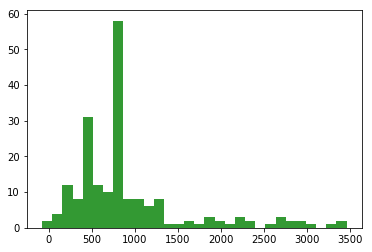

In [59]:
# dictExcerpt1 = hashesToDict(hashesExcerpt1)
count1, delta_k1 = match_fingerprint(dictExcerpt1, dictOriginal)
if delta_k1:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    numBins = 30
    ax.hist(delta_k1,numBins,color='green',alpha=0.8)

# Exercise 5.

Now load the second file, count the number of matches, and plot the histogram of the offsets.

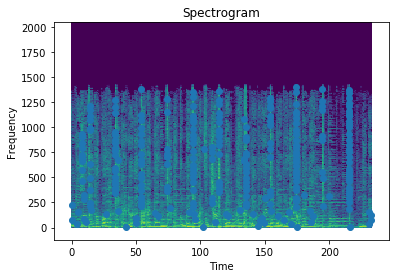

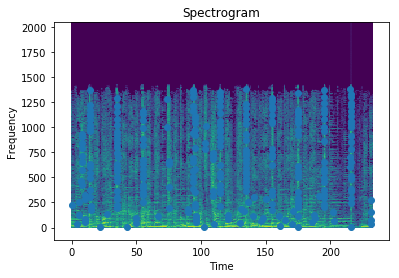

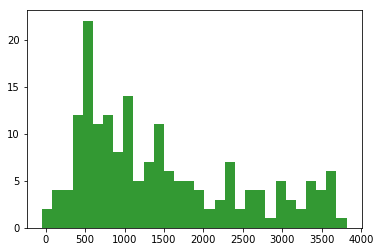

In [60]:
channelsExcerpt2, framerate = readAudioFileExcerpt('data/Gia-Nhu-Anh-Lang-Im.wav', 40,50)

#write code to generate hashesExcerpt2
plot = True

wsize  = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
amp_min = 25 # minimum amplitude of the peak.

for samples in channelsExcerpt2:
    hashesExcerpt2 = fingerprint(samples, framerate, wsize, wratio, fan_value, amp_min, plot)

dictExcerpt2 = hashesToDict(hashesExcerpt2)
count2, delta_k2 = match_fingerprint(dictExcerpt2, dictOriginal)
if delta_k2:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    numBins = 30
    ax.hist(delta_k2,numBins,color='green',alpha=0.8)

# Exercise 6. 
Based on the number of matches (consider how many possible matches there are) and histogram of offsets, justify that your code produces a desirable result. 

**We should expect the full song to produce a lower number of matches due to the increased probability of hash collisions when using the full song as opposed to a snippet.**

# Exercise 7.
Now to test the system. Create your own dataset (of at least 100 songs) to test the accuracy of the Shazam system. You will need to generate a dictionary for each song. Use 10% of the songs in the dataset to test for recognition accuracy. Change the length of the hash (len_hash) (try several different values from 10 to 25) and amplitude threshold (amp_min) (try several different values from 5 to 10) and compare the accuracy, speed, and size of the dictionary. What do you think is the optimal trade-off?

In [70]:
import os
files = []
for filename in os.listdir("data/ShazamFiles"):
    files.append(readAudioFile("data/ShazamFiles/" + filename))

**Extra Credit.** There is one component not yet implemented, which is reading the audio snippet from the microphone. This is not mandatory, but you can try it yourself if you have time. It is suggested to use [pyaudio](http://people.csail.mit.edu/hubert/pyaudio/). 